In [46]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import linalg
import control
import dubins
from dubins import calcDubinsPath,dubins_traj,Waypoint
import math
from numpy import random
random.seed(10)
from scipy.spatial import distance
from scipy import interpolate

### Generate Dubin's Path

No RLR Path
No LRL Path


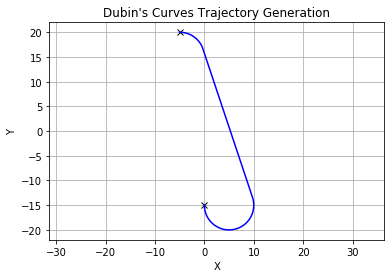

In [47]:
pt1 = Waypoint(0,-15,-180)
pt2 = Waypoint(-5,20,-90)
#pt3 = Waypoint(1000,15000,180)
#pt4 = Waypoint(0,0,270)
Wptz = [pt1, pt2]
# Run the code
i = 0
while i<len(Wptz)-1:
    param = calcDubinsPath(Wptz[i], Wptz[i+1], 5)
    path = dubins_traj(param,10000)
  
    # Plot the results
    plt.plot(Wptz[i].x,Wptz[i].y,'kx')
    plt.plot(Wptz[i+1].x,Wptz[i+1].y,'kx')
    plt.plot(path[:,0],path[:,1],'b-')
    i+=1
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves Trajectory Generation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


### Create the true trajectory

##### First, find the closest points, get the correspoinding heading angle, then interpolate between them to create the true trajectory

In [48]:
def closest_node(node, nodes):
    closest_index = distance.cdist(node, nodes).argmin()
    return closest_index

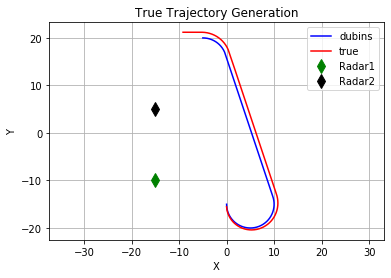

In [49]:
# Start point, 0,-15, and Starting Theta: -90
Xk_1=path[0][0]
yk_1=path[0][1]
ThetaK_1=path[0][2]
n=len(path)
P=path
del_T=0.5
Q=np.zeros((1,2))
samp=124
traj=np.zeros((samp,2))
mean = [0, 0]
cov = [[0.05**2, 0], [0, 0.05**2]]
# s=1+random.multivariate_normal(mean, cov, samp);
s= 1+np.random.normal(0.0, (0.05), size=(10000,1))
idxx=[]
for k in range(samp): 
#     s_k= np.abs(0.05 * np.random.randn(1, 1))
    Xk=Xk_1 +del_T*(s[k])*math.cos((ThetaK_1))
    Yk=yk_1 +del_T*(s[k])*math.sin((ThetaK_1))
    Q[:,0]=Xk
    Q[:,1]=Yk
    traj[k][0]=Xk
    traj[k][1]=Yk
    close_idx=closest_node(Q, P[:,:-1])
    ThetaK_1 = P[close_idx][2]
    idxx.append(close_idx)
#     ThetaK_1=math.atan2( P[close_idx][1]-Yk,P[close_idx][0]-Xk)
  
    Xk_1=Xk
    yk_1=Yk

# interpolate traj to make it 10000 grid points. 
x_spce = np.linspace(0,1,124)
xnew_spc = np.linspace(0,1,10000)
tck_x = interpolate.splrep(x_spce, traj[:,0], s=0)
tck_y = interpolate.splrep(x_spce, traj[:,1], s=0)
x_intrp = interpolate.splev(xnew_spc, tck_x, der=0)
y_intrp = interpolate.splev(xnew_spc, tck_y, der=0)

plt.plot(P[:,0],P[:,1],'b-',label= 'dubins')
plt.plot(x_intrp,y_intrp,'r-',label='true')
plt.plot(-15,-10,'gd',markersize=10,label='Radar1')
plt.plot(-15,5,'kd',markersize=10,label='Radar2')
plt.grid(True)
plt.axis("equal")
plt.title('True Trajectory Generation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

## Radar Set 1
#### Sensor's Measurements

In [50]:
samp=10000
mean = [0, 0, 0]
cov = [[9*(np.pi/180)**2, 0, 0], [0, 9*(np.pi/180)**2, 0], [0, 0, 5*(np.pi/180)**2]]
V1,V2,V3=random.multivariate_normal(mean, cov, samp).T;
# Bearing and Heading measurements
x1=-15
y1=-10
x2=-15
y2=5
y_meas=np.zeros((samp,3));
for k in range(samp):
    Beta1=np.array(math.atan(math.radians((y_intrp[k]-y1)//(x_intrp[k]-x1)))+V1[k])
    Beta2=np.array(math.atan(math.radians((y_intrp[k]-y2)//(x_intrp[k]-x2)))+V2[k])
    Theta_k=np.array(P[k][2]+V3[k])
    y_meas[k,0]=Beta1
    y_meas[k,1]=Beta2
    y_meas[k,2]=Theta_k


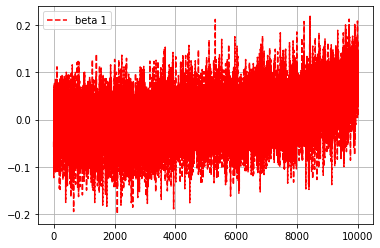

In [51]:
#plt.plot(y_meas[:,0],label='Beta1')
plt.plot(y_meas[:,0],'--r',label='beta 1')
plt.legend()
plt.grid(True)
plt.show()

### Find F, H, L, M through finding the Jacobian

In [52]:
import sympy as sp
from sympy import *
x, y,delt, sn, w1n,w2n, theta,x1n,x2n,y1n,y2n,v1n,v2n,v3n = sp.symbols(['x','y','delt','sn','w1n','w2n','theta','x1n','x2n','y1n','y2n','v1n','v2n','v3n'])

Mtrx = Matrix([[x+delt*(sn+w1n)*cos(theta)], [y+delt*(sn+w1n)*sin(theta)],[theta+w2n]])
Mtrx

Matrix([
[delt*(sn + w1n)*cos(theta) + x],
[delt*(sn + w1n)*sin(theta) + y],
[                   theta + w2n]])

In [53]:
F = Mtrx.jacobian([[x], [y], [theta]])
F

Matrix([
[1, 0, -delt*(sn + w1n)*sin(theta)],
[0, 1,  delt*(sn + w1n)*cos(theta)],
[0, 0,                           1]])

In [54]:
L = Mtrx.jacobian([[w1n], [w2n]])
L

Matrix([
[delt*cos(theta), 0],
[delt*sin(theta), 0],
[              0, 1]])

In [55]:
h=Matrix([[atan((y-y1n)/(x-x1n))+v1n],[atan((y-y2n)/(x-x2n))+v2n],[theta+v3n]])
h

Matrix([
[v1n + atan((y - y1n)/(x - x1n))],
[v2n + atan((y - y2n)/(x - x2n))],
[                    theta + v3n]])

In [56]:
H=h.jacobian([[x], [y], [theta]])
H

Matrix([
[-(y - y1n)/((1 + (y - y1n)**2/(x - x1n)**2)*(x - x1n)**2), 1/((1 + (y - y1n)**2/(x - x1n)**2)*(x - x1n)), 0],
[-(y - y2n)/((1 + (y - y2n)**2/(x - x2n)**2)*(x - x2n)**2), 1/((1 + (y - y2n)**2/(x - x2n)**2)*(x - x2n)), 0],
[                                                        0,                                             0, 1]])

In [57]:
M=h.jacobian([[v1n], [v2n], [v3n]])
M

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

### Define state Prediction function

In [58]:

def states_pred(state_ekf,dt,s,w,i):
    temp_state = np.array([state_ekf[i-1,0]+dt*(s[i]+w[i,0])*math.cos(math.radians(state_ekf[i-1,2])),\
                      state_ekf[i-1,1]+dt*(s[i]+w[i,1])*math.sin(math.radians(state_ekf[i-1,2])),\
                      state_ekf[i-1,2]+w[i,2]])
    
    return temp_state.T


### Define measurement output y_ekf function

In [59]:
def find_y_ekf(state_ekf,v,y1,y2,x1,x2,i):
    tmp_yekf=np.array([math.atan(math.radians((state_ekf[i,1]-y1)/(state_ekf[i,0]-x1)))+v[i,0],\
                      math.atan(math.radians((state_ekf[i,1]-y2)/(state_ekf[i,0]-x2)))+v[i,1],\
                      math.radians(state_ekf[i,2])+v[i,2]])
    
    return tmp_yekf.T

### Define Jacobian H

In [60]:
def H_jacobian(state_ekf,y1,y2,x1,x2,i):
    denom1=(state_ekf[i,0]-x1)**2+(state_ekf[i,1]-y1)**2
    denom2=(1+(state_ekf[i,1]-y1)**2/(state_ekf[i,0]-x1)**2)*((state_ekf[i,0]-x1))
    denom3=(state_ekf[i,0]-x2)**2+(state_ekf[i,1]-y1)**2
    denom4=(1+(state_ekf[i,1]-y1)**2/(state_ekf[i,0]-x1)**2)*((state_ekf[i,0]-x2))
    
    H= np.array([[-(state_ekf[i,1]-y1)/denom1, 1/denom2, 0],[-(state_ekf[i,1]-y2)/denom3, 1/denom4, 0],[0, 0 , 1]])
    return H
    

### Define Jacobian F

In [61]:
def F_jacobian(state_ekf,s,w,dt,i):
    F=np.array([[1,0, -dt*(s[i]+w[i,0])*math.sin(math.radians(state_ekf[i-1,2]))],[0,1,dt*(s[i]+w[i,1])*math.cos(math.radians(state_ekf[i-1,2]))],[0,0,1]])
    return F

### Define Jacobian L

In [62]:
def L_jacobian(state_ekf,dt,i):
    
    L=np.array([[dt*math.cos(math.radians(state_ekf[i-1,2])),0],[dt*math.sin(math.radians(state_ekf[i-1,2])),0],[0,1]])
    return L

### Initialize  P,Q,R,W,V

In [63]:
P_k_1=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
Q= np.array([[0.05**2, 0],[0, 0.04*0.25]])
R=np.array([[9*(np.pi/180)**2, 0, 0],[0, 9*(np.pi/180)**2, 0],[0, 0, 5*(np.pi/180)**2]])
M=np.eye(3)
mean1 = [0, 0, 0]
cov1 = [[9*(np.pi/180)**2, 0, 0], [0, 9*(np.pi/180)**2, 0], [0, 0, 5*(np.pi/180)**2]]
v=random.multivariate_normal(mean1, cov1, samp);
mean2 = [0, 0, 0]
cov2 = [[0.05**2, 0, 0], [0, 0.05**2, 0], [0, 0, 0.04*0.25]]
w=random.multivariate_normal(mean1, cov1, samp);

Xk_1=path[0][0]
yk_1=path[0][1]
ThetaK_1=path[0][2]
dt=0.05
state_ekf = np.zeros((samp,3));
state_ekf[0,:]=np.array([Xk_1,yk_1,ThetaK_1])
innovation=np.zeros((samp,3))
innovation[0,:]=y_meas[0,:]
P_k=np.zeros((samp,3,3))
P_k[0,:]=P_k_1
s_k=np.zeros((samp,3,3))

### Predictions and updates loop of EKF

In [64]:
for k in range(1,10000):
    state_ekf[k,:]=states_pred(state_ekf,dt,s,w,k)
    F=F_jacobian(state_ekf,s,w,dt,k)
    L=L_jacobian(state_ekf,dt,i)
    P_k[k,:]=np.array(F,dtype=float)@P_k[k-1,:]@np.array(F,dtype=float).T+L@Q@L.T
    y_ekf=find_y_ekf(state_ekf,v,y1,y2,x1,x2,k)
    H=H_jacobian(state_ekf,y1,y2,x1,x2,k)
    s_k[k,:]=H@P_k[k,:]@H.T+M@R@M.T
    gain_k=P_k[k,:]@H.T@np.linalg.inv(s_k[k,:])
    state_ekf[k,:]=state_ekf[k,:]+gain_k@(y_meas[k,:]-y_ekf)
    innovation[k,:]=y_meas[k,:]-y_ekf
    P_k=(P_k-gain_k@s_k[k,:]@gain_k.T)
    
 

### Plot the True and estimated trajectory

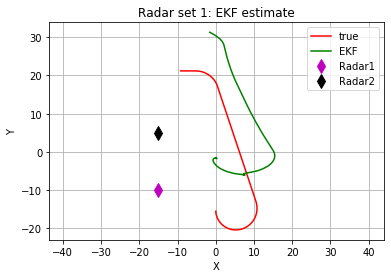

In [65]:
plt.plot(x_intrp,y_intrp,'r-',label='true')
plt.plot(state_ekf[:,0]/5,state_ekf[:,1]/10,'g-',label='EKF')
plt.plot(-15,-10,'md',markersize=10,label='Radar1')
plt.plot(-15,5,'kd',markersize=10,label='Radar2')
plt.grid(True)
plt.axis("equal")
plt.title('Radar set 1: EKF estimate')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

### Plot the a posteriori states

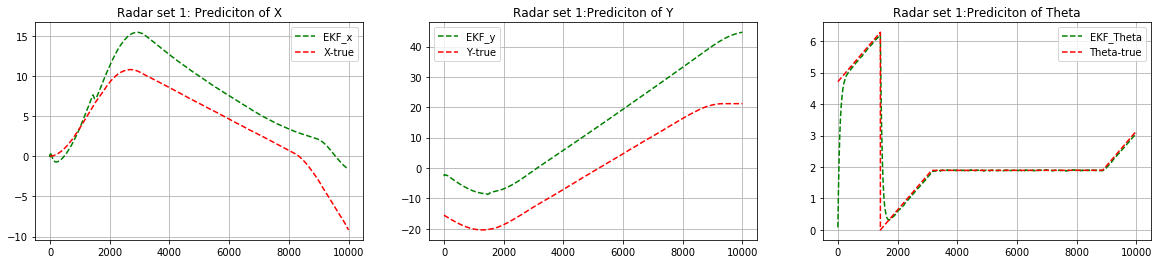

In [66]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(state_ekf[:,0]/5,'g--',label='EKF_x')
plt.plot(x_intrp,'r--',label='X-true')
plt.title('Radar set 1: Prediciton of X')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(state_ekf[:,1]/7,'g--',label='EKF_y')
plt.plot(y_intrp,'r--',label='Y-true')
plt.title('Radar set 1:Prediciton of Y')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,3)
plt.plot((state_ekf[:,2])*(np.pi/180),'g--',label='EKF_Theta')
plt.plot(P[:,2],'r--',label='Theta-true')
plt.title('Radar set 1:Prediciton of Theta')
plt.legend()
plt.show;
plt.grid(True)

### Plots the 2x std of Pk|k

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


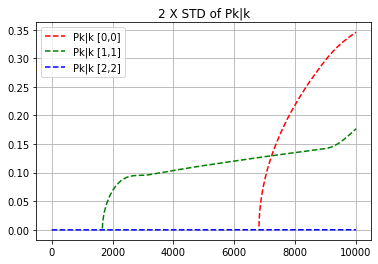

In [67]:

plt.plot(2*np.sqrt(np.array(P_k[:,0,0], dtype=np.float)),'r--',label='Pk|k [0,0]')
plt.plot(2*np.sqrt(np.array(P_k[:,1,1], dtype=np.float)),'g--',label='Pk|k [1,1]')
plt.plot(2*(np.array(P_k[:,1,1], dtype=np.float))/100,'b--',label='Pk|k [2,2]')
plt.title('2 X STD of Pk|k')
plt.legend()
plt.show;
plt.grid(True)



#### Pk|k[2,2] became NAN while taking an square root, that's why for Pk[2,2] I'm just plotting the covariance directly by scaling it down 

### Plot the Innovations

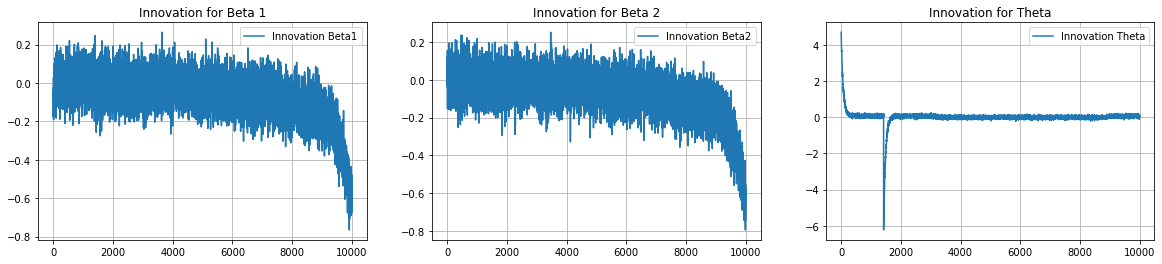

In [68]:

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(np.array(innovation[:,0],dtype=float),label='Innovation Beta1')
plt.title('Innovation for Beta 1')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(np.array(innovation[:,1],dtype=float),label='Innovation Beta2')
plt.title('Innovation for Beta 2')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(np.array(innovation[:,2],dtype=float),label='Innovation Theta')
plt.title('Innovation for Theta')
plt.legend()
plt.show;
plt.grid(True)

### 2xSTD of sk

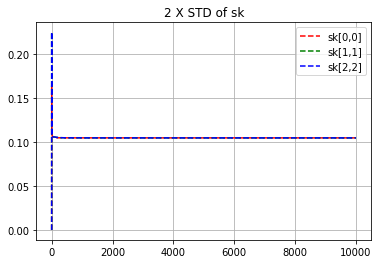

In [69]:
plt.plot(2*np.sqrt(np.array(s_k[:,0,0], dtype=np.float)),'r--',label='sk[0,0]')
plt.plot(2*np.sqrt(np.array(s_k[:,1,1], dtype=np.float)),'g--',label='sk[1,1]')
plt.plot(2*np.sqrt(np.array(s_k[:,1,1], dtype=np.float)),'b--',label='sk[2,2]')
plt.title('2 X STD of sk')
plt.legend()
plt.show;
plt.grid(True)

# -----------------  RADAR set 2 --------------------

In [70]:
samp=10000
mean = [0, 0, 0]
cov = [[9*(np.pi/180)**2, 0, 0], [0, 9*(np.pi/180)**2, 0], [0, 0, 5*(np.pi/180)**2]]
V1,V2,V3=random.multivariate_normal(mean, cov, samp).T;
# Bearing and Heading measurements
x1=-100
y1=-10
x2=-100
y2=5
y_meas=np.zeros((samp,3));
for k in range(samp):
    Beta1=np.array(math.atan(math.radians((y_intrp[k]-y1)//(x_intrp[k]-x1)))+V1[k])
    Beta2=np.array(math.atan(math.radians((y_intrp[k]-y2)//(x_intrp[k]-x2)))+V2[k])
    Theta_k=np.array(P[k][2]+V3[k])
    y_meas[k,0]=Beta1
    y_meas[k,1]=Beta2
    y_meas[k,2]=Theta_k


In [71]:
P_k_1=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
Q= np.array([[0.05**2, 0],[0, 0.04*0.25]])
R=np.array([[9*(np.pi/180)**2, 0, 0],[0, 9*(np.pi/180)**2, 0],[0, 0, 5*(np.pi/180)**2]])
M=np.eye(3)
mean1 = [0, 0, 0]
cov1 = [[9*(np.pi/180)**2, 0, 0], [0, 9*(np.pi/180)**2, 0], [0, 0, 5*(np.pi/180)**2]]
v=random.multivariate_normal(mean1, cov1, samp);
mean2 = [0, 0, 0]
cov2 = [[0.05**2, 0, 0], [0, 0.05**2, 0], [0, 0, 0.04*0.25]]
w=random.multivariate_normal(mean1, cov1, samp);

Xk_1=path[0][0]
yk_1=path[0][1]
ThetaK_1=path[0][2]
dt=0.05
state_ekf = np.zeros((samp,3));
state_ekf[0,:]=np.array([Xk_1,yk_1,ThetaK_1])
innovation=np.zeros((samp,3))
innovation[0,:]=y_meas[0,:]
P_k=np.zeros((samp,3,3))
P_k[0,:]=P_k_1
s_k=np.zeros((samp,3,3))

In [72]:
for k in range(1,10000):
    state_ekf[k,:]=states_pred(state_ekf,dt,s,w,k)
    F=F_jacobian(state_ekf,s,w,dt,k)
    L=L_jacobian(state_ekf,dt,i)
    P_k[k,:]=np.array(F,dtype=float)@P_k[k-1,:]@np.array(F,dtype=float).T+L@Q@L.T
    y_ekf=find_y_ekf(state_ekf,v,y1,y2,x1,x2,k)
    H=H_jacobian(state_ekf,y1,y2,x1,x2,k)
    s_k[k,:]=H@P_k[k,:]@H.T+M@R@M.T
    gain_k=P_k[k,:]@H.T@np.linalg.inv(s_k[k,:])
    state_ekf[k,:]=state_ekf[k,:]+gain_k@(y_meas[k,:]-y_ekf)
    innovation[k,:]=y_meas[k,:]-y_ekf
    P_k=(P_k-gain_k@s_k[k,:]@gain_k.T)
    

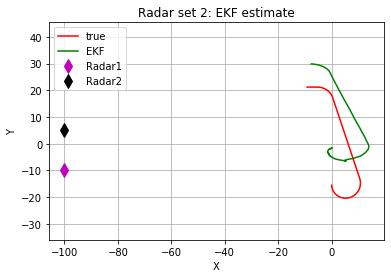

In [73]:
plt.plot(x_intrp,y_intrp,'r-',label='true')
plt.plot(state_ekf[:,0]/5,state_ekf[:,1]/10,'g-',label='EKF')
plt.plot(-100,-10,'md',markersize=10,label='Radar1')
plt.plot(-100,5,'kd',markersize=10,label='Radar2')
plt.grid(True)
plt.axis("equal")
plt.title('Radar set 2: EKF estimate')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

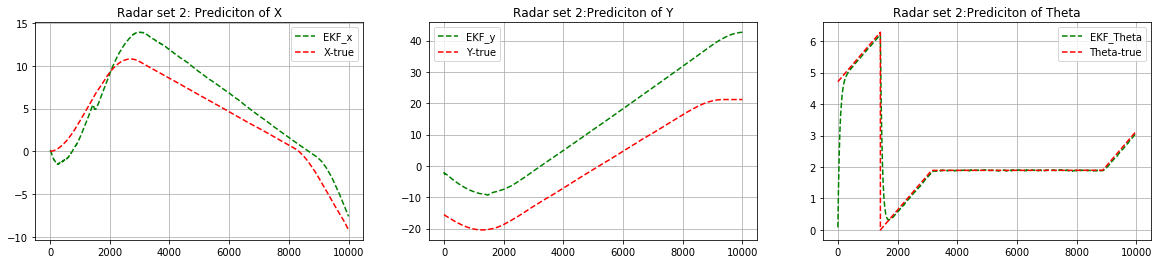

In [74]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(state_ekf[:,0]/5,'g--',label='EKF_x')
plt.plot(x_intrp,'r--',label='X-true')
plt.title('Radar set 2: Prediciton of X')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(state_ekf[:,1]/7,'g--',label='EKF_y')
plt.plot(y_intrp,'r--',label='Y-true')
plt.title('Radar set 2:Prediciton of Y')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,3)
plt.plot((state_ekf[:,2])*(np.pi/180),'g--',label='EKF_Theta')
plt.plot(P[:,2],'r--',label='Theta-true')
plt.title('Radar set 2:Prediciton of Theta')
plt.legend()
plt.show;
plt.grid(True)

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


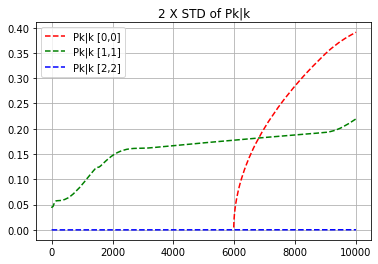

In [75]:
plt.plot(2*np.sqrt(np.array(P_k[:,0,0], dtype=np.float)),'r--',label='Pk|k [0,0]')
plt.plot(2*np.sqrt(np.array(P_k[:,1,1], dtype=np.float)),'g--',label='Pk|k [1,1]')
plt.plot(2*(np.array(P_k[:,1,1], dtype=np.float))/100,'b--',label='Pk|k [2,2]')
plt.title('2 X STD of Pk|k')
plt.legend()
plt.show;
plt.grid(True)

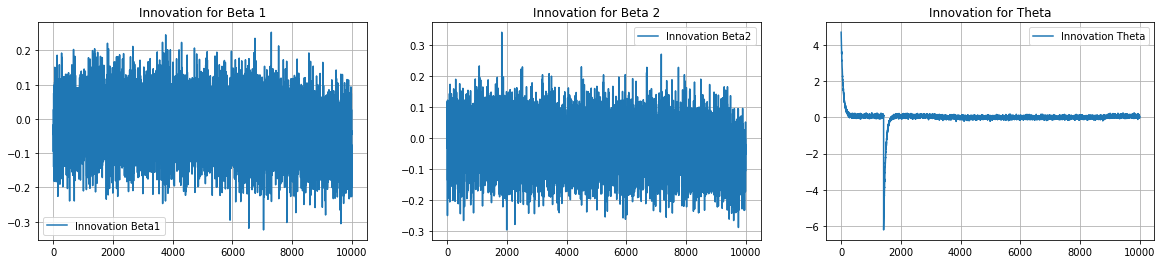

In [76]:

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(np.array(innovation[:,0],dtype=float),label='Innovation Beta1')
plt.title('Innovation for Beta 1')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(np.array(innovation[:,1],dtype=float),label='Innovation Beta2')
plt.title('Innovation for Beta 2')
plt.legend()
plt.show;
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(np.array(innovation[:,2],dtype=float),label='Innovation Theta')
plt.title('Innovation for Theta')
plt.legend()
plt.show;
plt.grid(True)

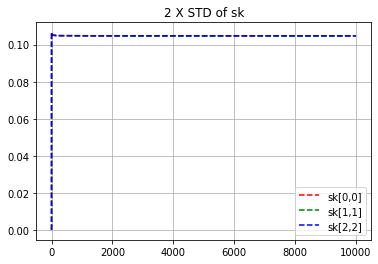

In [77]:
plt.plot(2*np.sqrt(np.array(s_k[:,0,0], dtype=np.float)),'r--',label='sk[0,0]')
plt.plot(2*np.sqrt(np.array(s_k[:,1,1], dtype=np.float)),'g--',label='sk[1,1]')
plt.plot(2*np.sqrt(np.array(s_k[:,1,1], dtype=np.float)),'b--',label='sk[2,2]')
plt.title('2 X STD of sk')
plt.legend()
plt.show;
plt.grid(True)

##### Trajectory tracking is not entirely accurate, althoug the shape of the trajectory was estimated correctly. This could be attributed to incorrect use of radion conversion of angles. While plotting the 2XSTD of pk|k and sk, it's been found that the covariance of the last diagoanl elements were vanishing. This could also be the reason why the esitamtion is off a bit. Hopefully by the time of next project, this could be sorted out